In [397]:
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import os
import datetime
from keras.utils.vis_utils import plot_model
from keras.layers import LSTM, Dense,Dropout
from keras.models import Sequential

# 數據讀取，並將日期欄位設為索引
train_df = pd.read_csv("Train_台北.csv",parse_dates=['日期'],index_col=['日期'])



In [398]:
# 顯示數據前五筆
train_df.head()

,進站人數,離站人數
日期,,
2018-01-01,92240,72909
2018-01-02,59275,62271
2018-01-03,55203,56412
2018-01-04,56380,56249
2018-01-05,65561,63962


In [399]:
# 去除離站人數資訊
train = train_df.drop(columns = ['離站人數'],axis=1)


In [400]:
# 顯示數據前五筆
train.head()

,進站人數
日期,
2018-01-01,92240
2018-01-02,59275
2018-01-03,55203
2018-01-04,56380
2018-01-05,65561


c:\Users\MSpace\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\MSpace\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


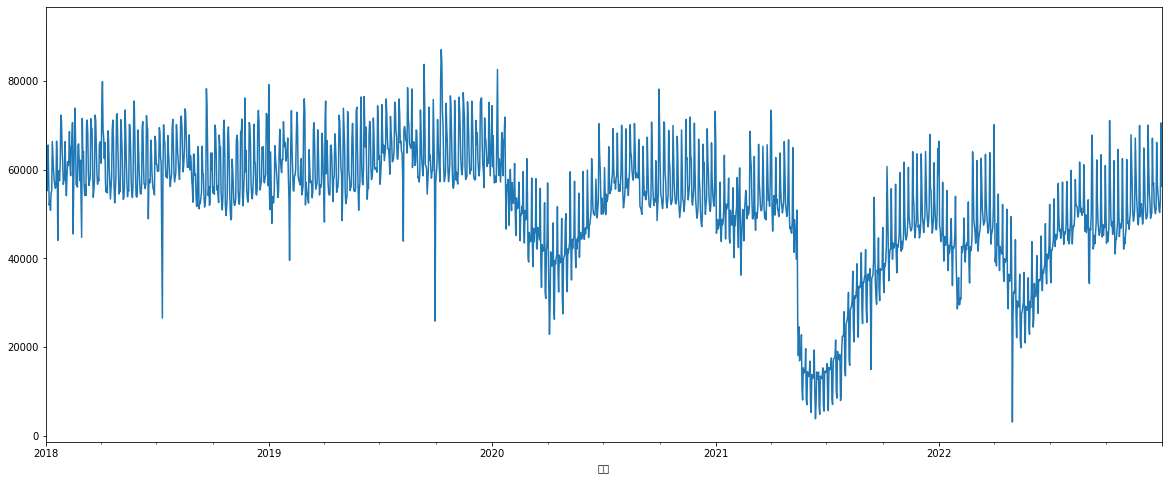

In [401]:
# 原始進站人數數據圖表
train['進站人數'].plot(figsize=(20,8))
plt.show()

In [402]:
# 數據歸一化，以便於模型訓練進行
scaler = MinMaxScaler()

train['進站人數'] = scaler.fit_transform(train_df['進站人數'].values.reshape(-1,1))

c:\Users\MSpace\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\MSpace\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


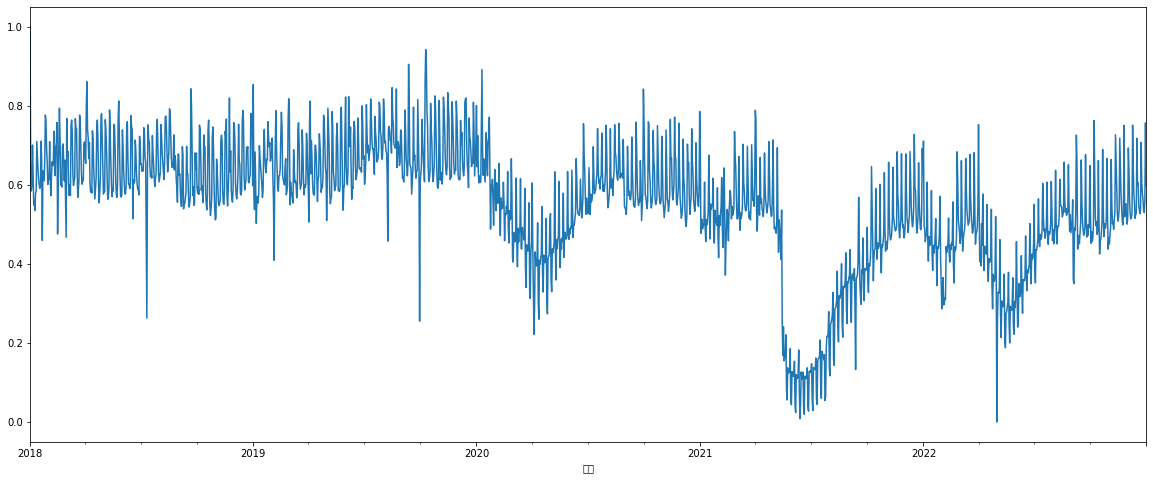

In [403]:
# 歸一化後數據顯示
train['進站人數'].plot(figsize=(20,8))
plt.show()

In [404]:
# 顯示歸一化後數據
train.head()

,進站人數
日期,
2018-01-01,1.000000
2018-01-02,0.630101
2018-01-03,0.584410
2018-01-04,0.597617
2018-01-05,0.700636


In [405]:
train.shape

(1826, 1)

In [406]:
# 建立特徵數據集與標籤集
def create_dataset(dataset, seq_len = 7):

    X = [] 
    y = [] 
    
    start = 0 
    end = dataset.shape[0] - seq_len 
    
    for i in range(start, end): 
        sample = dataset[i : i+seq_len] #創建樣本，如i=0則以0:7為樣本
        label = dataset[i+seq_len] #創建標籤，如i=0則將第8筆數據做為標籤
        X.append(sample) #保存樣本數據
        y.append(label) #保存標籤數據
    
    # 將特徵集與標籤集以numpy array格式返回
    return np.array(X), np.array(y)

In [407]:
# 將x,y分別定義為數據集與標籤集，時間以7天做切分
x,y = create_dataset(train.values,seq_len=7)

In [408]:
x.shape

(1819, 7, 1)

In [409]:
y.shape

(1819, 1)

In [410]:
# 特徵數據
x[0]

array([[1.        ],
       [0.63010133],
       [0.58440961],
       [0.59761667],
       [0.70063623],
       [0.62603934],
       [0.54864844]])

In [411]:
# 標籤數據
y[0]

array([0.56027334])

In [412]:
# 將建立好的特徵數據與標籤集切分為訓練集與測試集
def split_dataset(X, y, train_ratio=0.8):

    X_len = len(X) 
    train_data_len = int(X_len * train_ratio) 
    
    X_train = X[:train_data_len] 
    y_train = y[:train_data_len] 
    
    X_test = X[train_data_len:] 
    y_test = y[train_data_len:] 
    
    
    return X_train, X_test, y_train, y_test

In [413]:
# 將特徵數據集x與標籤集y分為訓練與測試集
X_train, X_test, y_train, y_test = split_dataset(x, y, train_ratio=0.8)

In [414]:
X_train.shape

(1455, 7, 1)

In [415]:
X_test.shape

(364, 7, 1)

In [416]:
y_train.shape

(1455, 1)

In [417]:
y_test.shape

(364, 1)

In [418]:
# 將X_train, X_test, y_train, y_test建立batch dataset
def create_batch(X, y, batch_size=128, data_type=1):
    # data_type區分,測試集為1,訓練集為2
    if data_type == 1: 
        dataset = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y))) #將x,y封裝為tensor類型
        test_batch_data = dataset.batch(batch_size) 
        
        return test_batch_data
    else: 
        dataset = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y))) 
        train_batch_data = dataset.cache().shuffle(1000).batch(batch_size) 
        
        return train_batch_data

In [419]:
# 建立train_batch_dataset
train_batch_dataset = create_batch(X_train, y_train, batch_size=256, data_type=2)

In [420]:
# 建立test_batch_dataset
test_batch_dataset = create_batch(X_test, y_test, batch_size=256, data_type=1)


In [421]:
# 模型構建
model = Sequential()
model.add(LSTM(8,input_shape=(7,1)))
model.add(Dense(1))
model.compile(optimizer='adam',loss = 'mse')


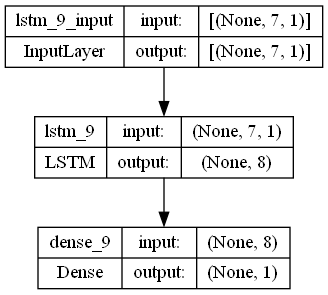

In [422]:
# 顯示模型結構
plot_model(model,to_file='model.png',show_shapes=True)

In [423]:
# 定義checkpoint並保存權重
file_path = "best_checkpoint.hdf5"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=file_path, 
                                                         monitor='loss', 
                                                         mode='min', 
                                                         save_best_only=True,
                                                         save_weights_only=True)

In [424]:
# 模型訓練
history = model.fit(train_batch_dataset,
          epochs=30,
          validation_data=test_batch_dataset,
          callbacks=[checkpoint_callback])

Epoch 1/30
6/6 [==============================] - 1s 62ms/step - loss: 0.1755 - val_loss: 0.1004
Epoch 2/30
6/6 [==============================] - 0s 9ms/step - loss: 0.1438 - val_loss: 0.0781
Epoch 3/30
6/6 [==============================] - 0s 8ms/step - loss: 0.1138 - val_loss: 0.0576
Epoch 4/30
6/6 [==============================] - 0s 9ms/step - loss: 0.0860 - val_loss: 0.0398
Epoch 5/30
6/6 [==============================] - 0s 8ms/step - loss: 0.0614 - val_loss: 0.0252
Epoch 6/30
6/6 [==============================] - 0s 9ms/step - loss: 0.0408 - val_loss: 0.0146
Epoch 7/30
6/6 [==============================] - 0s 8ms/step - loss: 0.0252 - val_loss: 0.0085
Epoch 8/30
6/6 [==============================] - 0s 9ms/step - loss: 0.0150 - val_loss: 0.0066
Epoch 9/30
6/6 [==============================] - 0s 8ms/step - loss: 0.0099 - val_loss: 0.0078
Epoch 10/30
6/6 [==============================] - 0s 8ms/step - loss: 0.0085 - val_loss: 0.0099
Epoch 11/30
6/6 [=====================

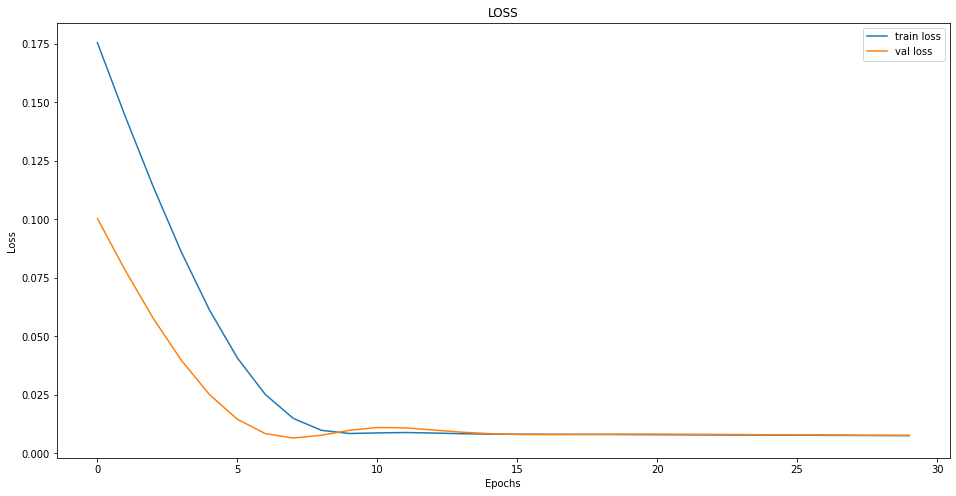

In [425]:
# 顯示loss值資訊
plt.figure(figsize=(16,8))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title("LOSS")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

In [426]:
# 模型驗證
test_pred = model.predict(X_test, verbose=1)

12/12 [==============================] - 0s 2ms/step


In [427]:
test_pred.shape

(364, 1)

In [428]:
y_test.shape

(364, 1)

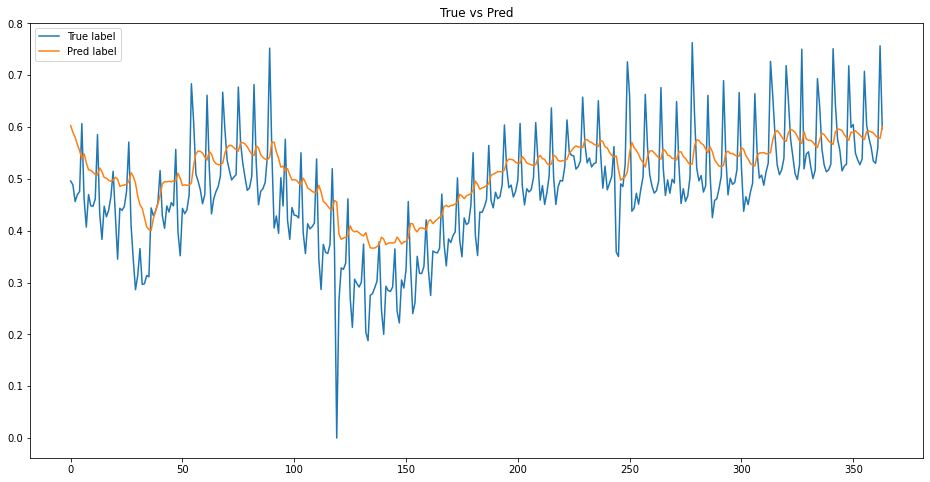

In [431]:
# 顯示模型驗證結果
plt.figure(figsize=(16,8))
plt.plot(y_test, label="True label")
plt.plot(test_pred, label="Pred label")
plt.title("True vs Pred")
plt.legend(loc='best')
plt.show()